## W to tau branching ratios

To estimate the branching ratio $W\rightarrow \tau\nu_{\tau}$, a template will be performed to the data collected in 2016 by CMS.  The basic idea is select on events consistent with $t\bar{t}$ production, form templates for the various decay modes and background processes, and then carry out a template fit to the data.  In general, a template fit can be thought of as an n-component mixture model such that,

$$
f(x) = \sum_{i} \alpha_{i}h_{i}(x),
$$

with the constraint that $\sum_{i}\alpha_{i} = 1$.  In our case the functional components are going to be histograms so that $h(x), f(x) \rightarrow h_{j}, h_{j}$.  The optimal (MLE) of the parameters $\alpha_{i}$ can be determined by minimizing the NLL give the data.  Because the dataset is large and the amount of data in each bin is large we will assume the data is distributed according to a Gaussian in each bin, i.e., the NLL will be the same as minimizing the $\chi^{2}$,

$$
\chi^{2} = \sum_{j} \frac{(y_{j} - f_{j})^{2}}{\sigma_{j}^{2}},
$$

where $y_{j}$ is the number of data events in bin $j$ and $\sigma_{j}^{2}$ corresponds to the variance.  The variance is the combination of the statistical error on the data ($\sigma_{j}^{2} = N_{j}$) and the statistical plus systematic uncertainty on the data model prediction(\textit{systematic uncertainties have not yet been considered for the data modelling, but will eventually be incorporated})

For this particular measurement there are some important additional considerations; primary among them is the fact that the mixture components $\alpha_{i}$ for the various decay components will be highly correlated.  This is because they will all have some dependencies on the underlying physical processes.  For example, one component that will be of interest will arise from the decay $t\bar{t}\rightarrow WbWb \rightarrow \mu\mu bb$, and another will arise from the decay $t\bar{t}\rightarrow WbWb \rightarrow \mu\tau_{\mu} bb$ (here $\tau_{\mu}$ indicates that the $\tau$ lepton subsequently decays to a muon).  The corresponding mixture amplitudes can be written,

$$
\alpha_{\mu\mu} = \frac{\epsilon_{\mu\mu}\beta_{\mu}^{2}}{\mathcal{A}},
$$
$$
\alpha_{\mu\mu_{\tau}} = \frac{2\epsilon_{\mu\tau}b_{\mu}\beta_{\mu}\beta_{\mu_{\tau}}}{\mathcal{A}}.
$$

This is the case for every mixture term associated with the signal decays.  For shorthand, I am writing the branching fraction of W to X as $\beta_{X}$ and the branching fraction of $\tau$ to X as $b_{X}$.  The $\epsilon$ term represents the combined efficiency and acceptance for that particular decay mode.  Also, there is the normalization factor $\mathcal{A}$ which is a sum over all signal processes.  (Technically, there is a factor of $\sigma_{signal}$ and $\mathcal{L}$ but these should cancel, I think).

In total we have 21 possible decay modes for double W production (as in the case of $t\bar{t}$) when we group together all hadronic final states and separate out the different $\tau$ decay modes.  Of these decay modes, there are four underlying branching fractions, 

$$
\boldsymbol{\beta} = \{\beta_{e}, \beta_{\mu}, \beta_{\tau}, \beta_{h}\},
$$

with a constraint that,

$$
\sum_{p}\beta_{p} = 1.
$$
Additionally there are three nuisance parameters for the decay of the $\tau$, 

$$
\mathbf{b} = \{b_{e}, b_{\mu}, b_{h}\}.
$$

These will be fixed to the PDG values and can at a later time be treated as nuisance parameters where we will marginalize over their uncertainties (which are small, ~0.1%).

In [160]:
# imports and configuration
%cd '/home/naodell/work/CMS/z_plus_jpsi'
%matplotlib notebook

from functools import partial
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize
from scipy.stats import chi2, beta
import numdifftools as nd

import scripts.plot_tools as pt

matplotlib.style.use('default')
params = {'legend.fontsize': 20,
          'axes.labelsize': 20,
          'axes.titlesize':'x-large',
          'xtick.labelsize':18,
          'ytick.labelsize':18,
         }
matplotlib.rcParams.update(params)
%matplotlib inline

/home/naodell/work/CMS/z_plus_jpsi


Before running this step, the templates must be generated using scripts/template_maker.py.  This will provide template histograms as well as efficiencies (estimated from MC) for the various decay modes of the WW pair.

In [161]:
# configure, get the input data, and do any additional processing that is needed
selection = 'mumu'
target    =  'lepton1_pt'
input_dir = f'data/templates/12162017/'

# get our data
decay_map    = pd.read_csv('data/decay_map.csv').set_index('id')['decay']
df_sig_eff   = pd.read_csv(input_dir + f'{selection}_signal_eff.csv', skiprows=1, names=['decay_mode', 'eff']).set_index('decay_mode')
df_templates = pd.read_csv(input_dir + f'{selection}_{target}_val.csv').set_index('bins')
df_vars      = pd.read_csv(input_dir + f'{selection}_{target}_var.csv').set_index('bins')

# calculate inital bg fraction and variance
n_sig, n_bg = df_templates[decay_map.values].sum(), df_templates['bg'].sum()
var_sig, var_bg = df_vars[decay_map.values].sum(), df_vars['bg'].sum()
norm, var_norm = n_sig.sum() + n_bg, var_sig.sum() + var_bg
alpha_bg = n_bg/norm
#var_alpha_bg = alpha_bg*(1 - alpha_bg)*var_norm/norm**2 # got to think if this is right...
var_alpha_bg = var_bg/norm**2 

In [162]:
# normalize the templates to unity and scale the errors
norms = df_templates.sum(axis=0)
df_templates /= norms
#df_vars *= df_templates*(1-df_templates)/norms**2 # think about this too
df_vars /= norms**2
df_templates, df_vars = df_templates.fillna(0), df_vars.fillna(0)

# split template dataframe into data, bg, and signal, and then convert to numpy arrays
# (handled in the mixutre model class in the future)
eff    = df_sig_eff['eff'].values
data   = (df_templates['data'].values, df_vars['data'].values)
bg     = (df_templates['bg'].values, df_vars['bg'].values)
signal = (df_templates[decay_map.values].values, df_vars[decay_map.values].values)

I'll define the signal and total mixture here.  The signal mixture has 21 terms and it's important that the ordering of all the various inputs match up.  The column ordering is specified in `df_decay_map`.

In [163]:
# fit functions
def signal_mixture_model(beta, br_tau, eff, h_temp):
    '''
    Mixture model for the ttbar/tW signal model.  The output will be an array corresponding 
    to a sum over the input template histograms scaled by their respective efficiencies
    and branching fraction products.
    
    parameters:
    ==========
    beta : branching fractions for the W decay
    br_tau : branching fractions for the tau decay
    eff: array consisting of efficiencies for each of the W/tau decay modes
    h_temp : a tuple with the template histograms and their errors
    ''' 
    
    amplitudes = np.array([beta[0]*beta[0], # e, e
                           beta[1]*beta[1], # mu, mu
                           2*beta[0]*beta[1], # e, mu
                           beta[2]*beta[2]*br_tau[0]**2, # tau_e, tau_e
                           beta[2]*beta[2]*br_tau[1]**2, # tau_mu, tau_mu
                           2*beta[2]*beta[2]*br_tau[0]*br_tau[1], # tau_e, tau_mu
                           2*beta[2]*beta[2]*br_tau[0]*br_tau[2], # tau_e, tau_h 
                           2*beta[2]*beta[2]*br_tau[1]*br_tau[2], # tau_mu, tau_h 
                           beta[2]*beta[2]*br_tau[2]*br_tau[2], # tau_h, tau_h 
                           2*beta[0]*beta[2]*br_tau[0], # e, tau_e
                           2*beta[0]*beta[2]*br_tau[1], # e, tau_mu
                           2*beta[0]*beta[2]*br_tau[2], # e, tau_h
                           2*beta[1]*beta[2]*br_tau[0], # mu, tau_e
                           2*beta[1]*beta[2]*br_tau[1], # mu, tau_mu
                           2*beta[1]*beta[2]*br_tau[2], # mu, tau_h
                           2*beta[0]*beta[3], # e, h
                           2*beta[1]*beta[3], # mu, h
                           2*beta[2]*beta[3]*br_tau[0], # tau_e, h
                           2*beta[2]*beta[3]*br_tau[1], # tau_mu, h
                           2*beta[2]*beta[3]*br_tau[2], # tau_h, h
                           beta[3]*beta[3], # tau_h, h
                          ])
    mix_amps = eff*amplitudes
    norm = mix_amps.sum()
    f   = np.dot(h_temp[0], mix_amps/norm)
    var = np.dot(h_temp[1], mix_amps**2/norm**2)
    return f, var

def mixture_cost(params, br_tau, eff, t_data, t_bg, t_signal, const_params):
    '''
    Cost functionfor full data model.  Consists of  components:
    '''
    alpha0 = params[0]
    beta   = params[1:]
    
    f_bg, var_bg   = t_bg[0], t_bg[1]
    f_sig, var_sig = signal_mixture_model(beta, br_tau, eff, t_signal)
    f   = alpha0*f_bg + (1 - alpha0)*f_sig
    var = alpha0**2*var_bg + (1 - alpha0)**2*var_sig
    
    chi2 = (t_data[0] - f)**2 / (t_data[1] + var)
    chi2 = chi2[chi2 > 0]
    
    cost = np.sum(chi2) 
    
    # Include parameter constraints in the objective
    p_init = const_params['vals'] 
    v_init = const_params['var'] 
    lmult  = const_params['mask'] 
    
    chi2 = (params - p_init)**2 / v_init
    cost += np.sum(np.dot(chi2, lmult))
    return cost

def param_constraint_prior(p):
    #p_init = [0.1065, 0.1059, 0.114, 0.676] # lep values
    p_init = np.array([0.037, 0.108, 0.108, 0.108, 0.676]) 
    s_init = np.array([0.003, 0.0017, 0.0015, 0.0022, 0.0031])
    lmult  = np.array([1, 1, 1, 0, 1])
    
    cost = np.dot(lmult, p_init - p)
    return cost

def param_constraint_unitary(p):
    cost = np.abs(1 - np.sum(p[1:]))
    return cost

In [164]:
# initial values for W branching fraction (beta_e, beta_mu, beta_tau, beta_h)
#beta_init = [0.108, 0.108, 0.108, 0.676] # lepton universality (lep averate)
#var_beta  = [0.0009**2, 0.0009**2, 0.0009**2, 0.0031**2]
beta_init =[0.1065, 0.1059, 0.114, 0.676]
var_beta  = [0.0017**2, 0.0015**2, 0.0022**2, 0.0031**2]
mask  = np.array([1, 1, 1, 0, 1])

# initial values for tau branching fraction (b_e, b_mu, beta_h)
br_tau = [0.1783, 0.1741, 0.6476]

# first parameter is for the background component
p_init = dict(vals = np.array([alpha_bg] + beta_init),
              var  = np.array([var_alpha_bg] + var_beta),
              mask = mask
             )
bounds = [(0., 1.), (0.104, 0.109), (0.10, 0.12), (0, 1), (0.674, 679)]

constraints  = [
                dict(type = 'eq', fun = param_constraint_unitary),
                #dict(type = 'eq', fun = param_constraint_prior)
               ]

result = minimize(mixture_cost,
                  p_init['vals'],
                  method      = 'SLSQP',
                  bounds      = bounds,
                  constraints = constraints,
                  args        = (br_tau, eff, data, bg, signal, p_init)
                 ) 
f_cost = partial(mixture_cost, br_tau=br_tau, eff=eff, t_data=data, t_bg=bg, t_signal=signal, const_params=p_init)

hcalc = nd.Hessian(f_cost,
                   step        = 1e-2, #[5e-3*p for p in params],
                   method      = 'central',
                   full_output = True
                  )

hobj = hcalc(result.x)[0]
if np.linalg.det(hobj) != 0:
    # calculate the full covariance matrix in the case that the H
    hinv        = np.linalg.pinv(hobj)
    sig         = np.sqrt(hinv.diagonal())
    corr_matrix = hinv/np.outer(sig, sig)

np.set_printoptions(precision=4)
pd.set_option('precision', 4)
result_table = dict(
                    index = ['alpha_bg', 'beta_e', 'beta_mu', 'beta_tau', 'beta_h'], 
                    value = result.x,
                    error = sig
                   )
result_table = pd.DataFrame(result_table).set_index('index')
result_table[['value', 'error']]

,value,error
index,,
alpha_bg,0.0415,0.0022
beta_e,0.1057,0.0012
beta_mu,0.1045,0.0011
beta_tau,0.1157,0.0081
beta_h,0.6740,0.0022


In [165]:
# print correlation matrix
corr_matrix = pd.DataFrame(corr_matrix,
                           columns=['alpha_bg', 'beta_e', 'beta_mu', 'beta_tau', 'beta_h'], 
                           index=['alpha_bg', 'beta_e', 'beta_mu', 'beta_tau', 'beta_h']
                          )
corr_matrix

,alpha_bg,beta_e,beta_mu,beta_tau,beta_h
alpha_bg,1.0000e+00,-5.4429e-05,2.0541e-02,-0.5113,3.8963e-05
beta_e,-5.4429e-05,1.0000e+00,-6.2966e-06,-0.0008,-5.4702e-07
beta_mu,2.0541e-02,-6.2966e-06,1.0000e+00,0.1176,-1.1076e-05
beta_tau,-5.1131e-01,-7.9589e-04,1.1765e-01,1.0000,-3.6713e-03
beta_h,3.8963e-05,-5.4702e-07,-1.1076e-05,-0.0037,1.0000e+00


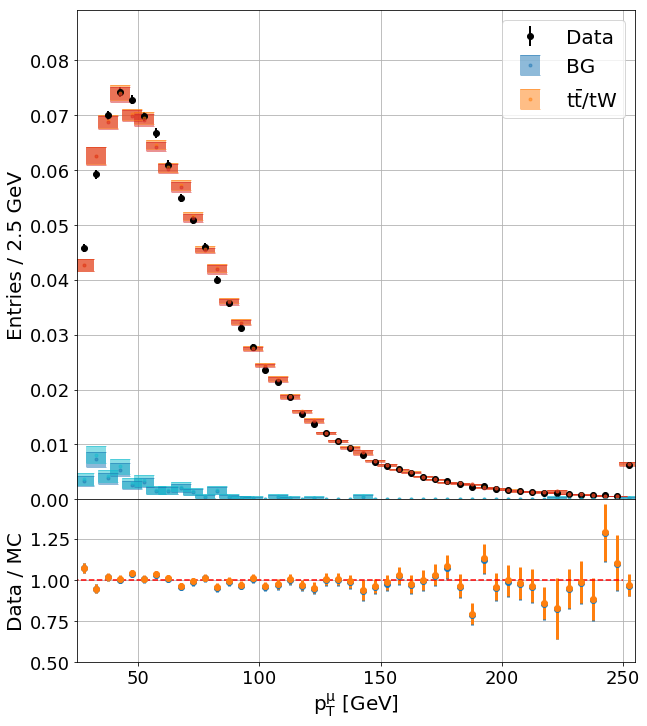

In [171]:
# make some plots
fig, axes = plt.subplots(2, 1, figsize=(10, 12), facecolor='white', sharex=True, gridspec_kw={'height_ratios':[3,1]})
fig.subplots_adjust(hspace=0)
#colors = [f'C{i}' for i in range(a_fit.size)]

bins = df_templates.index.values
xmin, xmax = bins.min(), bins.max()
dx = (bins[1:] - bins[:-1])/2
dx = np.append(dx, dx[-1])
x = bins + dx

# the data
y_data, yerr_data = data[0], np.sqrt(data[1])
axes[0].errorbar(x, y_data, yerr_data,
                 fmt        = 'ko',
                 capsize    = 0,
                 elinewidth = 2
                )

# signal and bg (prefit)
y_bg, yerr_bg = alpha_bg*bg[0], alpha_bg*np.sqrt(bg[1])
axes[0].errorbar(x, y_bg, yerr_bg,
                 fmt        = 'C0.',
                 capsize    = 10,
                 elinewidth = 20,
                 alpha = 0.5
                )

y_bg, yerr_bg = result.x[0]*bg[0], result.x[0]*np.sqrt(bg[1])
axes[0].errorbar(x, y_bg, yerr_bg,
                 fmt        = 'C9.',
                 capsize    = 10,
                 elinewidth = 20,
                 alpha = 0.5,
                 label = '_nolegend_'
                )

y_sig, yvar_sig = signal_mixture_model(beta_init, br_tau, eff, signal)
y_combined, yerr_combined = y_bg + (1 - alpha_bg)*y_sig, np.sqrt(yerr_bg**2 + (1 - alpha_bg)**2*yvar_sig)
axes[0].errorbar(x, y_combined, yerr_combined,
                 fmt        = 'C1.',
                 capsize    = 10,
                 elinewidth = 20,
                 alpha = 0.5
                )
ratio_pre = y_data/y_combined
ratio_pre_err = (1/y_combined**2)*np.sqrt(y_data**2*yerr_combined**2 + y_combined**2*yerr_data**2)

y_sig, yvar_sig = signal_mixture_model(result.x[1:], br_tau, eff, signal)
y_combined, yerr_combined = y_bg + (1 - result.x[0])*y_sig, np.sqrt(yerr_bg**2 + (1 - result.x[0])**2*yvar_sig)
axes[0].errorbar(x, y_combined, yerr_combined,
                 fmt        = 'C3.',
                 capsize    = 10,
                 elinewidth = 20,
                 alpha = 0.5,
                 label = '_nolegend_'
                )
ratio_post = y_data/y_combined
ratio_post_err = (1/y_combined**2)*np.sqrt(y_data**2*yerr_combined**2 + y_combined**2*yerr_data**2)


axes[0].grid()
axes[0].set_ylabel(r'Entries / 2.5 GeV')
axes[0].set_xlim(25, 255)
axes[0].set_ylim(0., 1.2*np.max(y))
axes[0].legend([
                'Data',
                r'BG',
                r'$\sf t\bar{t}/tW$',
                ])

#axes[0].text(80, 2200, r'$\alpha = $' + f' {result.x[0]:3.4} +/- {sig[0]:2.2}', {'size':20})

### calculate ratios
axes[1].errorbar(x, ratio_pre, ratio_pre_err,
                 fmt        = 'C0o',
                 ecolor     = 'C0',
                 capsize    = 0,
                 elinewidth = 3,
                 alpha = 1.
                )
axes[1].errorbar(x, ratio_post, ratio_post_err,
                 fmt        = 'C1o',
                 ecolor     = 'C1',
                 capsize    = 0,
                 elinewidth = 3,
                 alpha = 1.
                )

#ratio_post = y/h_post[-1]
#ratio_err = np.sqrt(y/h_post[-1]**2 + (y*herr/h_post[-1]**2)**2)
#axes[1].errorbar(x, ratio_post, ratio_err,
#                 fmt        = 'C1o',
#                 ecolor     = 'C1',
#                 capsize    = 0,
#                 elinewidth = 3,
#                 alpha = 1.
#                )
#
axes[1].grid()
axes[1].set_xlabel(r'$\sf p_{T}^{\mu}$ [GeV]')
axes[1].set_ylabel('Data / MC')
axes[1].set_ylim(0.5, 1.49)
#axes[1].legend(['prefit', 'postfit'], loc=1, fontsize=16)
axes[1].plot([xmin, xmax], [1, 1], 'r--')


plt.savefig('plots/fit_mumu_channel.pdf')
plt.show()